In [ ]:
# get_all_NDR.ipynb
# Script to save normalized, deblazed spectra and registered wavelength scales for input APF spectra.
# Last modified 8/12/20 by Anna Zuckerman


In [ ]:
import import_ipynb 
import numpy as np
import astropy.io.fits as pf
from astropy.io import fits
from bstar_deblaze import bstar_deblazed2
import sys
import os
sys.path.append('specmatch-emp')
import specmatchemp.library
import specmatchemp.plots as smplot
from specmatchemp.spectrum import Spectrum
from specmatchemp.specmatch import SpecMatch
from rescale import get_rescaled_wave_soln
from rescale import resample


In [ ]:
path_to_dir = '/mnt_blpd0/datax/apf' # Breakthrough Listen APF database
filelist = sorted(os.listdir(path_to_dir))
filelist.remove('apf_log.txt') # remove log files
filelist.remove('apf_log_current.txt')
filelist.remove('apf_log_current_new.txt')
filelist.remove('apf_log_current_25mar2019.txt')

bad_files = []
for file_name in filelist: 
    if not(file_name.startswith('ucb')):        
        try:
            # deal with directories
            if file_name.startswith('HIP') or os.path.isdir('./'+ file_name): # is a directory of spectra
                path = ('./' + file_name)
                spectra = sorted(os.listdir(path))
                data = np.zeros((79, 4608))
                for spectrum in spectra:
                    file = pf.open(path + '/' + spectrum)
                    data_part = file[0].data
                    if (str(np.shape(data_part)) != '(79, 4608)'):
                        print(str(np.shape(data_part)) + ' is an incompatible data shape.')
                        print('Cannot perform shift-and-match process.')
                        sys.exit()
                    data += data_part
            else: # just one spectrum
                file = pf.open(path_to_dir + '/' + file_name)
                old_header = file[0].header
                data = file[0].data

            orders  = np.linspace(30,51,22).astype(int)
            norm_deblazed = np.zeros([len(orders), 4600])
            for order in orders:
                data[order,:4600]  = bstar_deblazed2(data, order)
                norm_deblazed[order-30] = data[order,:4600]

            # Use Specmatch-Emp to get registered wavelength scale
            # Get a wavelength solution rescaled onto the scale of the library
            wave_soln_ref = get_rescaled_wave_soln()

            # Resample the spectrum onto the new wavelength scale
            wave_soln = (pf.open('apf_wav.fits'))[0].data
            data_new = resample(wave_soln_ref, wave_soln, data)

            # Create spectrum object
            my_spectrum = Spectrum(np.asarray(wave_soln_ref), np.asarray(data_new))

            lib = specmatchemp.library.read_hdf()

            sm = SpecMatch(my_spectrum, lib)

            # Perform shift
            sm.shift()

            # get target and wavelength
            target = sm.target.s
            target_wl = sm.target.w   

            # save to fits file
            new_header = old_header
            new_header.set('NRD', 'YES','Normalized, registered, deblazed')
            data_hdu = fits.PrimaryHDU(norm_deblazed, new_header) # could save 'data' instead if also want non-deblazed orders
            wl_hdu = fits.ImageHDU(target_wl)
            hdu = fits.HDUList([data_hdu, wl_hdu])

            save_name = file_name.split('.')[0] + '.' + file_name.split('.')[1] + '.NDR.' + file_name.split('.')[2]
            hdu.writeto('APF_spectra/NDR/' + save_name)
            print('Done: ' + save_name)
        except:
            print('Error occured processing file: ' + file_name)
            bad_files = bad_files + [file_name]

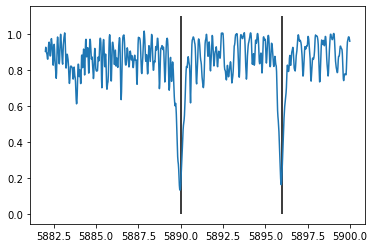

In [44]:
# Check that wavelength scale is properly registered
idxs_of_order45 = np.where((5882 < target_wl) * (target_wl < 5900))
plt.figure();plt.plot(target_wl[idxs_of_order45],target[idxs_of_order45])
plt.vlines([5890,5896], 0, 1.1,) # Na-D features